# EDA (Exploratory Data Analysis) of the dataset

In this notebook, explore the Abalone dataset, by showing relevant visualizations that help understand the problem you are modelling.

Please make sure to write down your conclusions in the final notebook and to remove these intructions.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


# Configuration
CSV_PATH = Path("../data/abalone.csv")
SAVE_CLEAN = True
CLEAN_PATH = CSV_PATH.with_name("abalone_clean.csv")
PD_DISPLAY_ROWS = 200

pd.set_option("display.max_rows", PD_DISPLAY_ROWS)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 500)

# Data

In [2]:
df_raw = pd.read_csv(CSV_PATH)
print("\n=== Raw head ===")
print(df_raw.head())


=== Raw head ===
  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  Shell weight  Rings
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010         0.150     15
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485         0.070      7
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415         0.210      9
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140         0.155     10
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395         0.055      7


# EDA

Making column names to snake_case

In [3]:
def to_snake(s: str) -> str:
    """
    Convert a string to clean, snake_case format.

    Parameters
    ----------
    s : str
        Input string (e.g., a column name).

    Returns
    -------
    str
        Cleaned string in snake_case format.

    Examples
    --------
    >>> to_snake("Shell Weight (grams)")
    'shell_weight_grams'

    """
    s = s.strip().lower().replace("/", " per ").replace("-", " ")

    s = "".join(ch if ch.isalnum() or ch.isspace() else "_" for ch in s)

    s = "_".join(s.split())

    while "__" in s:
        s = s.replace("__", "_")

    return s

In [4]:
df = df_raw.copy()
df.columns = [to_snake(c) for c in df.columns]

In [5]:
print("\n=== Columns ===")
print(df.columns.tolist())


=== Columns ===
['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']


Basic Quality checks

In [6]:
print("\n=== Shape ===")
print(df.shape)


=== Shape ===
(4177, 9)


In [7]:
print("\n=== Dtypes ===")
print(df.dtypes)


=== Dtypes ===
sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings               int64
dtype: object


In [8]:
print("\n=== Missing values per column ===")
print(df.isna().sum().sort_values(ascending=False))


=== Missing values per column ===
sex               0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
rings             0
dtype: int64


In [9]:
dup_count = df.duplicated().sum()
print(f"\n=== Duplicates: {dup_count} rows ===")


=== Duplicates: 0 rows ===


Derived target: Age (years) for EDA

In [10]:
if "rings" in df.columns:
    df["age"] = df["rings"] + 1.5
else:
    df["age"] = np.nan
print("\n=== Added column: age = rings + 1.5 ===")


=== Added column: age = rings + 1.5 ===


The target feature for us is Rings.

Each ring on the abalone shell corresponds roughly to one year of growth, after the first 1.5 years of the animal’s life.

So, the biological age is approximately number of rings + 1.5 years.

Descriptive statistics

In [11]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("\n=== Descriptive stats (numeric) ===")
print(df[num_cols].describe().T)

if "sex" in df.columns:
    by_sex = df.groupby("sex")[num_cols].agg(
        ["count", "mean", "std", "min", "median", "max"]
    )
    # flatten multiindex
    by_sex.columns = [
        "_".join([c for c in col if c]) for col in by_sex.columns.to_flat_index()
    ]
    print("\n=== By Sex: numeric summary ===")
    print(by_sex)


=== Descriptive stats (numeric) ===
                 count       mean       std     min     25%      50%     75%      max
length          4177.0   0.523992  0.120093  0.0750  0.4500   0.5450   0.615   0.8150
diameter        4177.0   0.407881  0.099240  0.0550  0.3500   0.4250   0.480   0.6500
height          4177.0   0.139516  0.041827  0.0000  0.1150   0.1400   0.165   1.1300
whole_weight    4177.0   0.828742  0.490389  0.0020  0.4415   0.7995   1.153   2.8255
shucked_weight  4177.0   0.359367  0.221963  0.0010  0.1860   0.3360   0.502   1.4880
viscera_weight  4177.0   0.180594  0.109614  0.0005  0.0935   0.1710   0.253   0.7600
shell_weight    4177.0   0.238831  0.139203  0.0015  0.1300   0.2340   0.329   1.0050
rings           4177.0   9.933684  3.224169  1.0000  8.0000   9.0000  11.000  29.0000
age             4177.0  11.433684  3.224169  2.5000  9.5000  10.5000  12.500  30.5000

=== By Sex: numeric summary ===
     length_count  length_mean  length_std  length_min  length_median 

1. Target (Rings / Age):

    Median = 9, IQR = [8, 11], mean = 9.93, max = 29 .

    Most abalones are mid-aged, very old ones are rare.


2. Size (Length & Diameter):

    Length mean = 0.524, 75th = 0.615, max = 0.815
    Diameter mean = 0.408, 75th = 0.480, max = 0.650

    Both are moderately right-skewed — consistent with biological growth.
   
3. Weights (Whole, Shucked, Viscera, Shell):

    Strong right skew; a few very heavy abalones exist.
    Whole weight mean = 0.829, 75th = 1.153, max = 2.826

4. Height:
    Median ≈ 0.140, 75th = 0.165, but min = 0.000, max = 1.130
    Zeros likely measurement errors.


By Sex — Biological Differences

Infants much smaller, females slightly larger.

Adults are older; infants are youngest.


Univariate distributions

In [12]:
def hist_series(
    series: pd.Series, title: str, bins: int = 20, xlabel: str | None = None
) -> None:
    """
    Plot a histogram for a numeric pandas Series.

    Parameters
    ----------
    series : pd.Series
        Numeric data to visualize.
    title : str
        Plot title.
    bins : int, optional
        Number of histogram bins. Default is 20.
    xlabel : str, optional
        Label for the x-axis. Defaults to the title if not provided.

    Returns
    -------
    None
        Displays the histogram.

    """
    s = series.dropna()
    plt.figure(figsize=(6, 4))
    plt.hist(s, bins=bins, color="steelblue", edgecolor="black", alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel or title)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

In [13]:
def boxplot_series(series: pd.Series, title: str) -> None:
    """
    Plot a boxplot for a numeric pandas Series.

    Parameters
    ----------
    series : pd.Series
        Numeric data to visualize.
    title : str
        Plot title (also used as the y-axis label).

    Returns
    -------
    None
        Displays the boxplot.

    """
    s = series.dropna()
    plt.figure(figsize=(5, 4))
    plt.boxplot(
        s,
        vert=True,
        patch_artist=True,
        boxprops=dict(facecolor="lightblue", color="black"),
        medianprops=dict(color="red", linewidth=1.5),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(marker="o", color="black", alpha=0.5),
    )
    plt.title(title)
    plt.ylabel(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

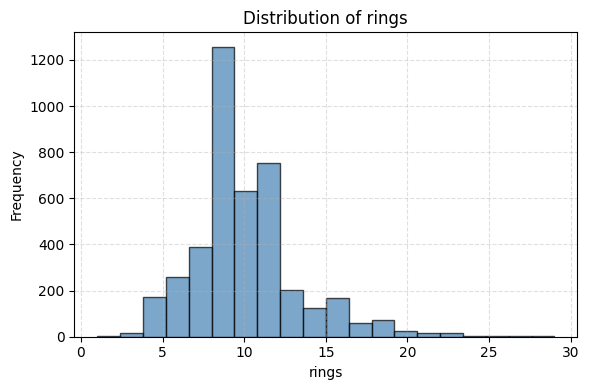

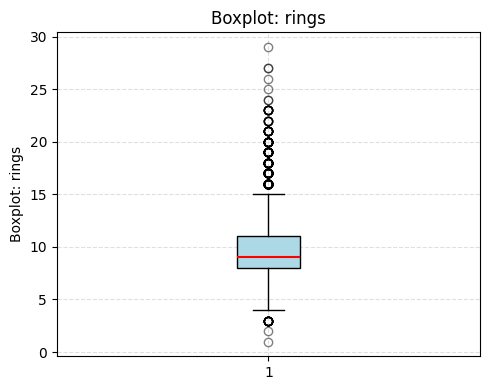

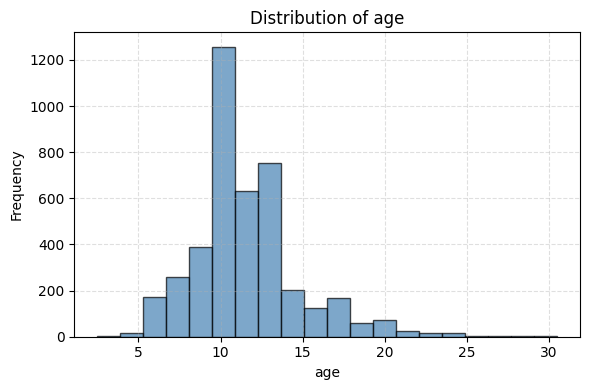

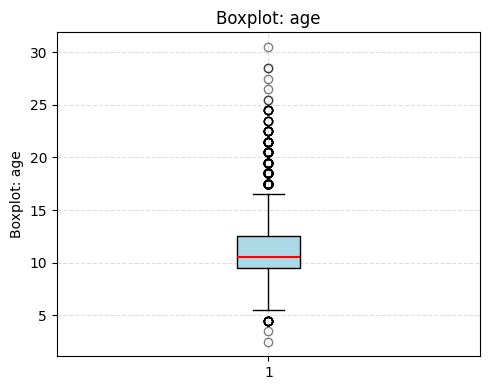

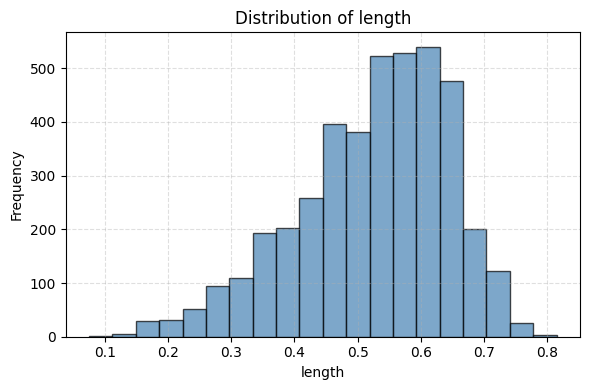

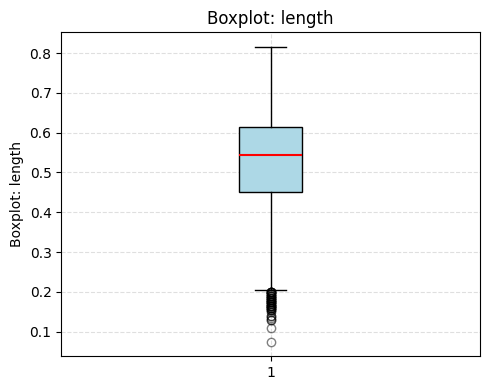

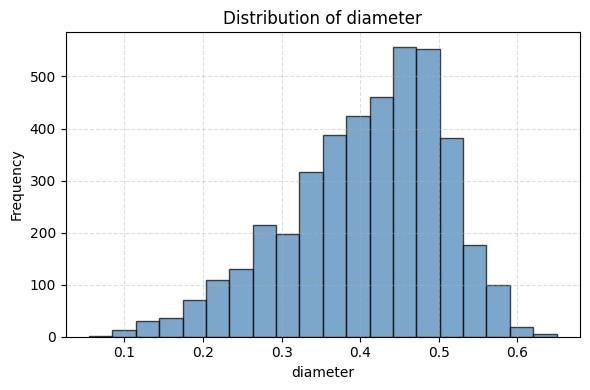

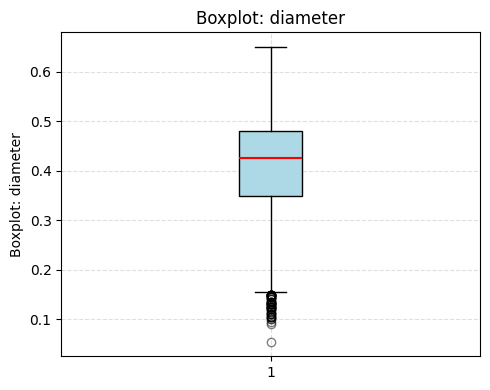

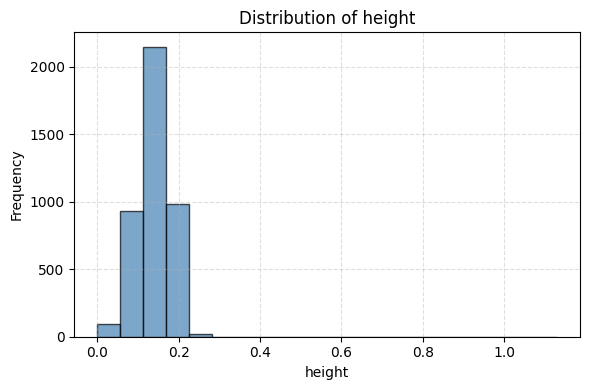

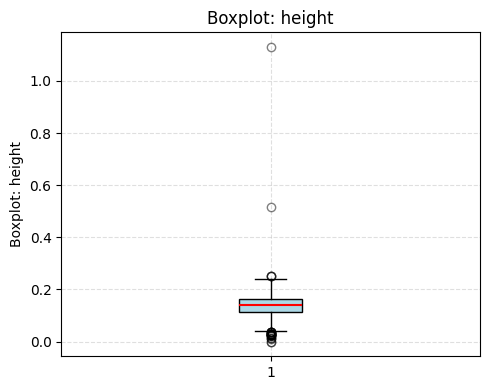

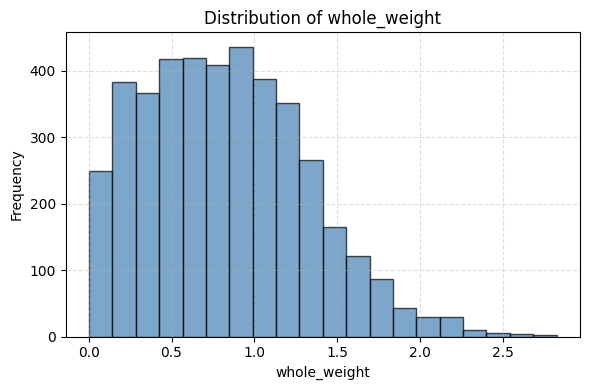

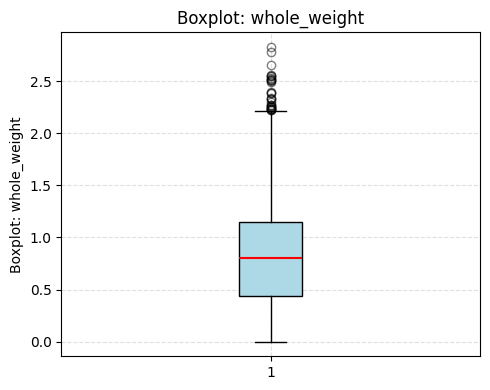

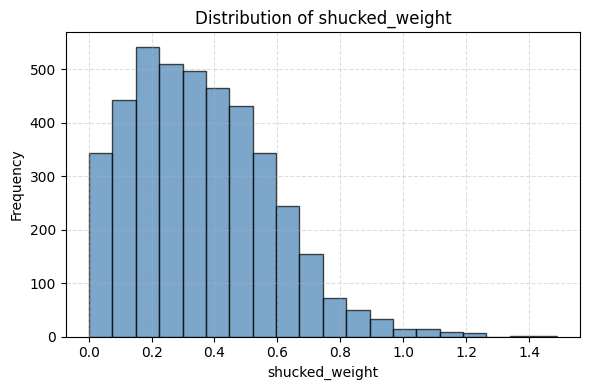

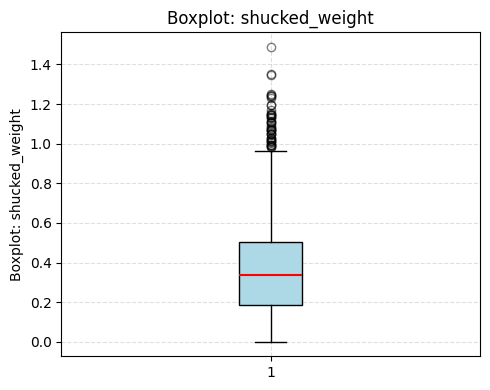

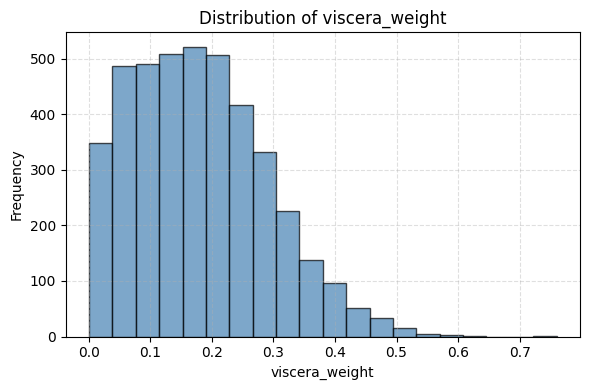

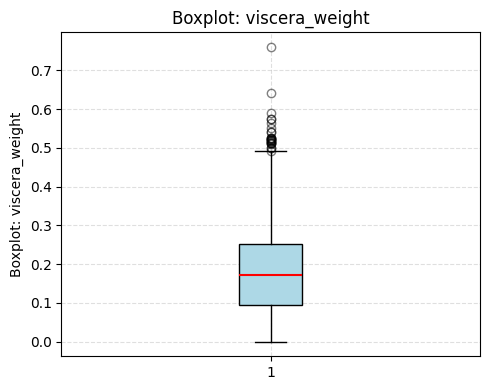

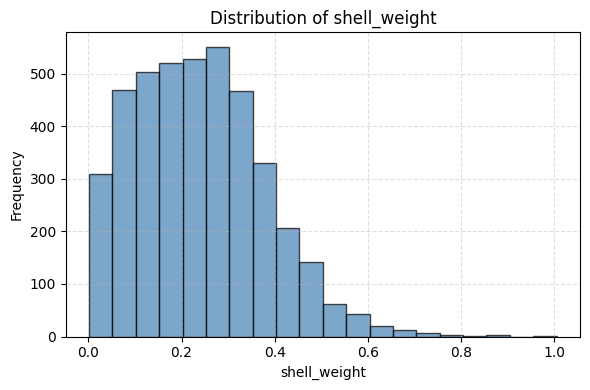

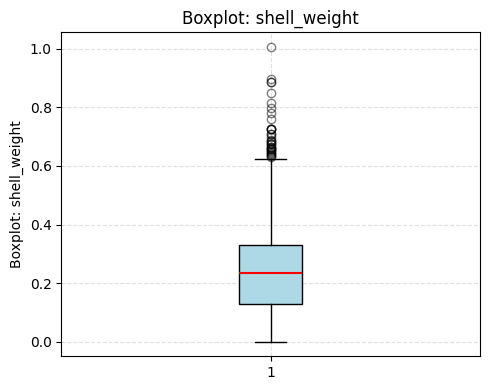

In [14]:
for col in [
    "rings",
    "age",
    "length",
    "diameter",
    "height",
    "whole_weight",
    "shucked_weight",
    "viscera_weight",
    "shell_weight",
]:
    if col in df.columns:
        hist_series(df[col], f"Distribution of {col}", bins=20, xlabel=col)
        boxplot_series(df[col], f"Boxplot: {col}")

### Target Variable: Rings (Age)

Histogram: Distribution of Rings

The histogram is right-skewed, peaking around 8–10 rings.
This suggests that most abalones are middle-aged, with fewer very young or very old ones.
A small tail exists beyond 20 rings, representing older abalones. We interpret that they are long-lived but rare.

Boxplot: Rings

The median lies around 9 rings.
A few outliers above 20 rings, indicating older, possibly large-sized abalones.
There are no extreme low outliers.

We infer that Growth rings generally cluster within a narrow band—abalones.

### Physical measurements

1. Feature: Length

    The histogram shows an approximately normal shape but slightly right-skewed. Most lengths cluster between 0.4 and 0.6.

    Boxplot shows very few large outliers.

    Length increases with age/rings but tapers off; it’s a reliable indicator of growth.

2. Feature: Diameter

    The histogram is almost identical to length.

    Boxplot shows slightly narrower spread than length.

    Diameter closely coorelates with length

3. Feature: Height

    Histogram is right-skewed, centered near 0.15–0.2.

    Boxplot shows outliers visible above 0.3.

    Height is smaller in scale and important to normalize before modeling.

4. Feature: Whole Weight

    Histogram is heavily right-skewed. Most abalones weigh <1.0, a few up to 2.5.

    Boxplot shows multiple high-end outliers.

    Older abalones weigh more. Skewness suggests weight grows faster at early stages then plateaus. 

5. Feature: Shucked Weight

    Histogram is similar to whole weight but with smaller magnitudes.

    Boxplot shows few outliers.

    Shucked Weight increases steadily with size and age. This seems to be a good growth indicator.

6. Feature: Viscera Weight

    Histogram is Right-skewed, clustered below 0.3.

    Boxplot shows outliers above 0.5.

    This feature helps capture biological maturity. 

7. Feature: Shell Weight

    Histogram shoes moderate right-skew.

    Boxplot shows some large shells (>0.6) as outliers.

    We infer that Shell weight accumulates with age. 




/var/folders/tc/ddy9q3l50gv9sy77lbp_p_cr0000gn/T/ipykernel_48468/4246057866.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sex', data=df, palette='Set2')


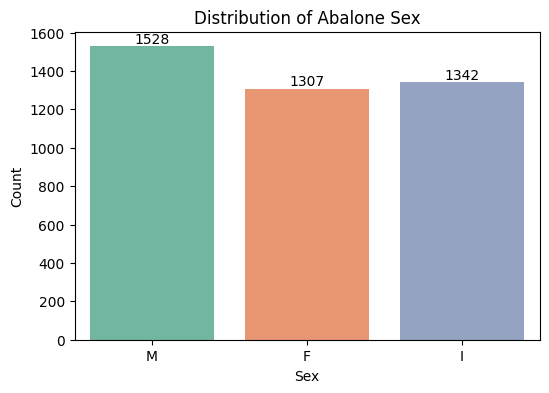

In [15]:
if "sex" in df.columns:
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x="sex", data=df, palette="Set2")

    # Add count labels above bars
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
        )

    plt.title("Distribution of Abalone Sex")
    plt.xlabel("Sex")
    plt.ylabel("Count")
    plt.show()
else:
    print("No 'sex' column found in the dataset.")

There are three classes:

1. M (Male): 1528 samples
2. F (Female): 1307 samples
3. I (Infant): 1342 samples

The distribution is fairly balanced.

Males are slightly more represented, while Females and Infants are almost equal.

This balance is ideal for modeling, since the dataset captures all life stages without bias.

Bivariate relationships

In [16]:
target = "rings" if "rings" in df.columns else None
features = [
    c
    for c in [
        "length",
        "diameter",
        "height",
        "whole_weight",
        "shucked_weight",
        "viscera_weight",
        "shell_weight",
    ]
    if c in df.columns
]

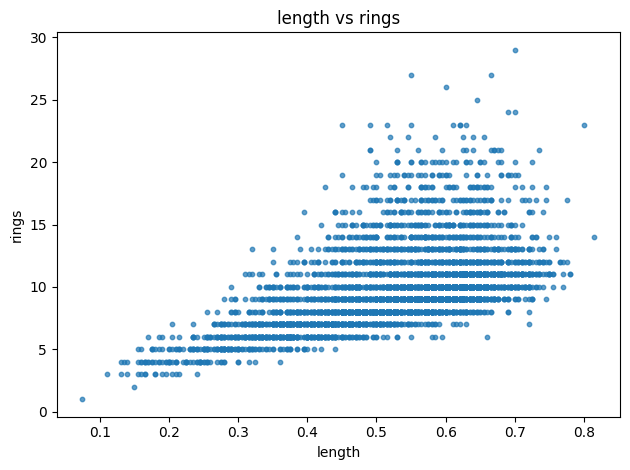

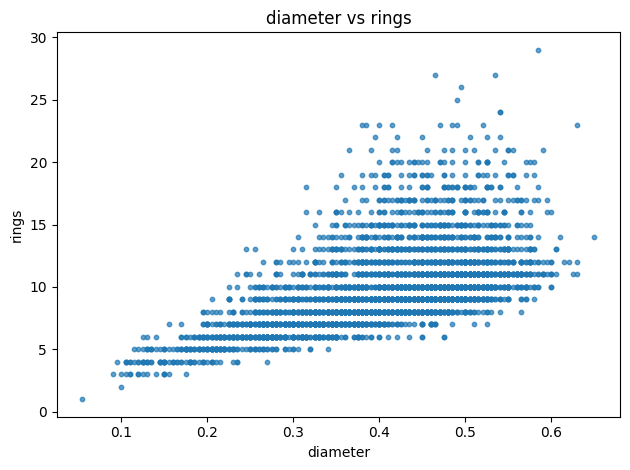

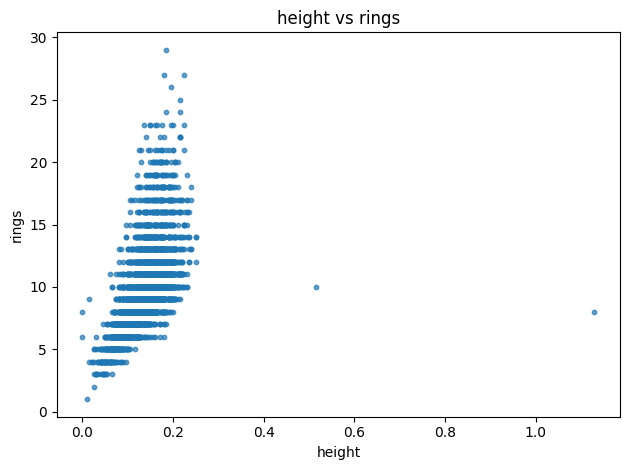

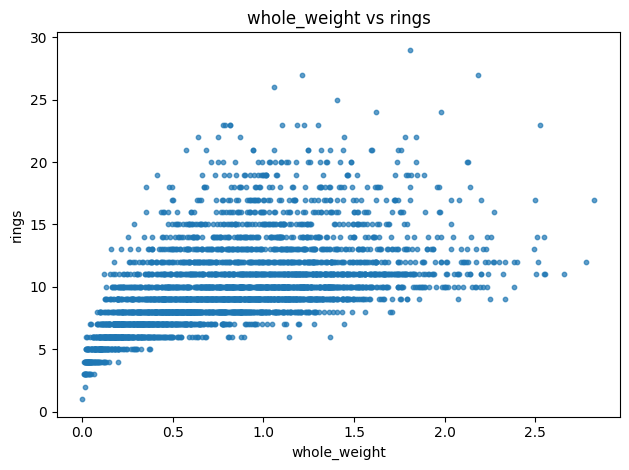

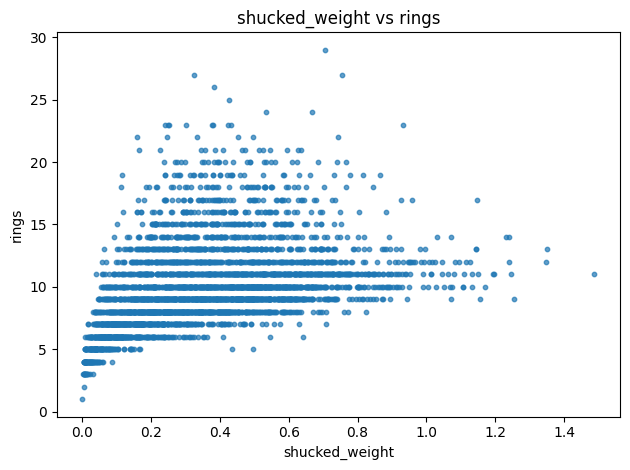

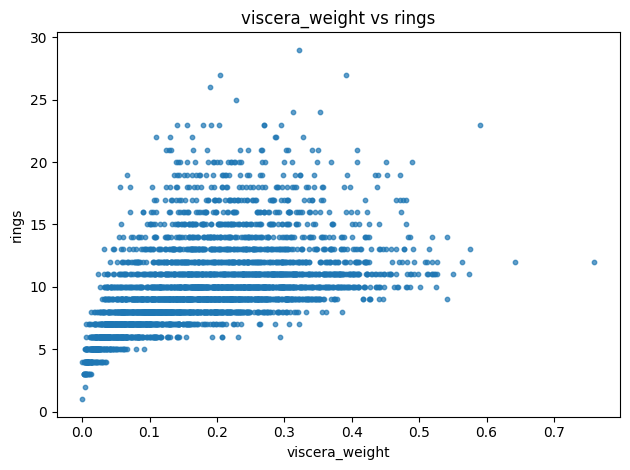

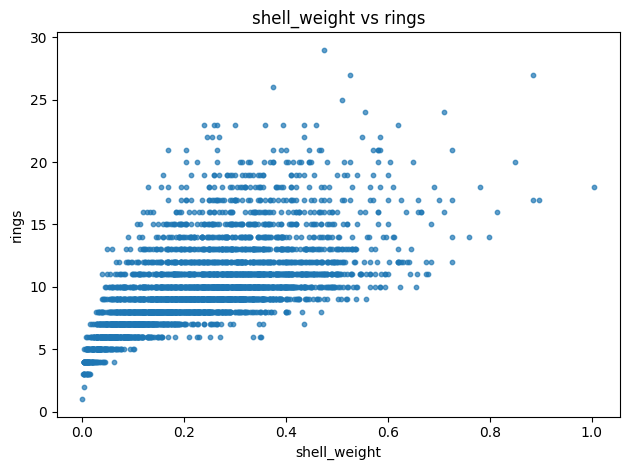

In [17]:
def scatter_xy(
    x: pd.Series,
    y: pd.Series,
    xlabel: str | None = None,
    ylabel: str | None = None,
    title: str | None = None,
) -> None:
    """
    Create a  scatter plot between two numeric pandas Series.

    Parameters
    ----------
    x : pd.Series
        Series representing the x-axis variable.
    y : pd.Series
        Series representing the y-axis variable.
    xlabel : str, optional
        Custom label for the x-axis. Defaults to x.name.
    ylabel : str, optional
        Custom label for the y-axis. Defaults to y.name.
    title : str, optional
        Plot title. Defaults to "<x.name> vs <y.name>".

    Returns
    -------
    None
        Displays the scatter plot.

    """
    xs = x.values
    ys = y.values
    plt.figure()
    plt.scatter(xs, ys, s=10, alpha=0.7)
    plt.xlabel(xlabel or x.name)
    plt.ylabel(ylabel or y.name)
    plt.title(title or f"{x.name} vs {y.name}")
    plt.tight_layout()
    plt.show()


if target is not None:
    for col in features:
        scatter_xy(
            df[col], df[target], xlabel=col, ylabel=target, title=f"{col} vs {target}"
        )

Scatter plots of Length vs Rings and Weight vs Rings show positive trends, that is, as size increases, so do rings.


There’s variance: older abalones can differ widely in weight (probably due to various environmental conditions).

Correlation matrix for numeric features


=== Correlation matrix (table) ===
                length  diameter  height  whole_weight  shucked_weight  viscera_weight  shell_weight  rings    age
length           1.000     0.987   0.828         0.925           0.898           0.903         0.898  0.557  0.557
diameter         0.987     1.000   0.834         0.925           0.893           0.900         0.905  0.575  0.575
height           0.828     0.834   1.000         0.819           0.775           0.798         0.817  0.557  0.557
whole_weight     0.925     0.925   0.819         1.000           0.969           0.966         0.955  0.540  0.540
shucked_weight   0.898     0.893   0.775         0.969           1.000           0.932         0.883  0.421  0.421
viscera_weight   0.903     0.900   0.798         0.966           0.932           1.000         0.908  0.504  0.504
shell_weight     0.898     0.905   0.817         0.955           0.883           0.908         1.000  0.628  0.628
rings            0.557     0.575   0.557    

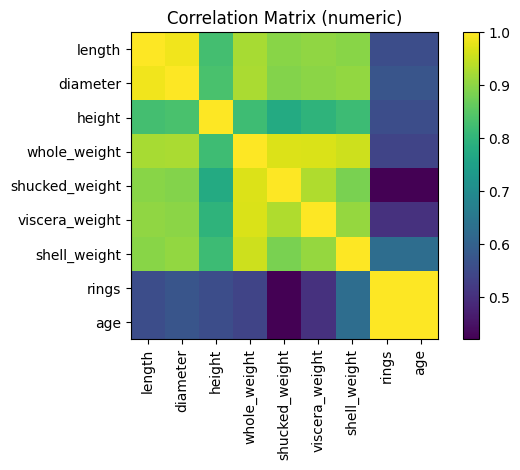

In [18]:
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    print("\n=== Correlation matrix (table) ===")
    print(corr.round(3))

    plt.figure()
    plt.imshow(corr, interpolation="nearest")
    plt.title("Correlation Matrix (numeric)")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

Age (Rings) is moderately correlated with size and weight features. 

It can be that older abalones are typically larger/heavier.

We also spotted high multicollinearity, 
For instance, Length and Diameter (0.99) and Weight features ↔ each other (0.96–0.97)
We can interpret that they measure related aspects of size.

Outlier detection and Handling

In [19]:
def iqr_outlier_count(s: pd.Series) -> int:
    """
    Count the number of outliers in a numeric Series using the IQR (Interquartile Range) method.

    Parameters
    ----------
    s : pd.Series
        Numeric pandas Series for which to detect outliers.

    Returns
    -------
    int
        The number of data points that fall outside the IQR range

    """
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return int(((s < lower) | (s > upper)).sum())


cols_to_check = features + (["rings", "age"] if "rings" in df.columns else [])
report = {
    c: iqr_outlier_count(df[c].dropna()) for c in cols_to_check if c in df.columns
}

print("\n=== IQR outlier counts ===")
print(pd.Series(report).sort_values(ascending=False))


=== IQR outlier counts ===
rings             278
age               278
diameter           59
length             49
shucked_weight     48
shell_weight       35
whole_weight       30
height             29
viscera_weight     26
dtype: int64


In [20]:
# Remove outliers from selected numeric columns using IQR rule
def remove_iqr_outliers(df, cols):
    df_clean = df.copy()
    for col in cols:
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        before = df_clean.shape[0]
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
        after = df_clean.shape[0]
        print(f"{col}: removed {before - after} outliers")
    return df_clean


cols_to_clean = [
    "length",
    "diameter",
    "height",
    "whole_weight",
    "shucked_weight",
    "viscera_weight",
    "shell_weight",
]

df_no_outliers = remove_iqr_outliers(df, cols_to_clean)

length: removed 49 outliers
diameter: removed 12 outliers
height: removed 8 outliers
whole_weight: removed 28 outliers
shucked_weight: removed 25 outliers
viscera_weight: removed 14 outliers
shell_weight: removed 28 outliers


In [21]:
print("Original shape:", df.shape)
print("After outlier removal:", df_no_outliers.shape)

Original shape: (4177, 10)
After outlier removal: (4013, 10)


In [22]:
df_no_outliers.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age
count,4013.000000,4013.000000,4013.000000,4013.000000,4013.000000,4013.000000,4013.000000,4013.000000,4013.000000
mean,0.524533,0.408242,0.139090,0.809481,0.350871,0.176759,0.233437,9.942935,11.442935
std,0.110511,0.091758,0.035588,0.445060,0.200989,0.100637,0.125749,3.117503,3.117503
min,0.205000,0.155000,0.040000,0.042500,0.017000,0.000500,0.013000,3.000000,4.500000
25%,0.450000,0.350000,0.115000,0.447500,0.189000,0.095000,0.131500,8.000000,9.500000
50%,0.540000,0.420000,0.140000,0.794500,0.334000,0.169000,0.230000,9.000000,10.500000
75%,0.610000,0.480000,0.165000,1.133000,0.493500,0.246500,0.320000,11.000000,12.500000
max,0.760000,0.600000,0.240000,2.127500,0.960000,0.480500,0.605000,29.000000,30.500000


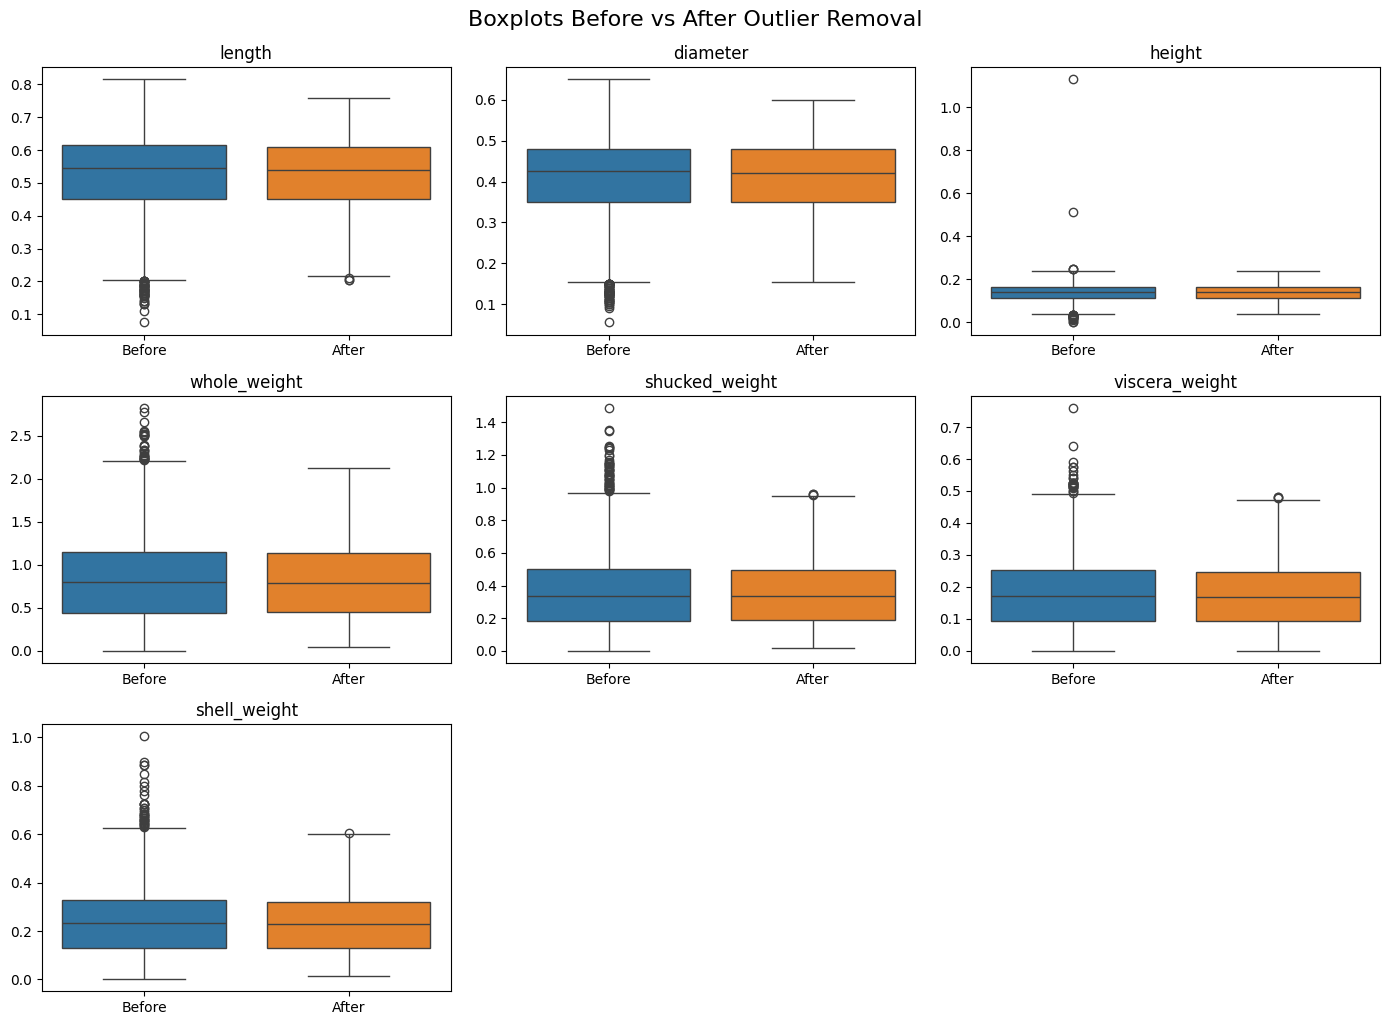

In [23]:
def compare_boxplots(
    df_before, df_after, exclude_cols=None, ncols=3, figsize=(14, 10)
) -> None:
    """
    Compare distributions (boxplots) before vs after outlier removal.

    Parameters
    ----------
    df_before : DataFrame
        Original dataset
    df_after : DataFrame
        Cleaned dataset
    exclude_cols : list, optional
        Columns to exclude (e.g., ['rings', 'age'])
    ncols : int, optional
        Number of columns per row in subplot grid
    figsize : tuple, optional
        Figure size
    """
    exclude_cols = exclude_cols or []
    cols = [
        c
        for c in df_before.select_dtypes(include="number").columns
        if c not in exclude_cols
    ]

    n_features = len(cols)
    nrows = (n_features + ncols - 1) // ncols
    plt.figure(figsize=figsize)

    for i, col in enumerate(cols, 1):
        plt.subplot(nrows, ncols, i)
        sns.boxplot(
            data=pd.DataFrame({"Before": df_before[col], "After": df_after[col]}),
            orient="v",
        )
        plt.title(col)
        plt.ylabel("")

    plt.tight_layout()
    plt.suptitle("Boxplots Before vs After Outlier Removal", fontsize=16, y=1.02)
    plt.show()


compare_boxplots(df, df_no_outliers, exclude_cols=["rings", "age"])

The distributions are now more compact, and the extreme outliers visible in the “Before” plots are largely removed.

Central tendency (median) remains almost unchanged.



In [24]:
if SAVE_CLEAN:
    df_no_outliers.to_csv(CLEAN_PATH, index=False)
    print(f"Saved outlier-removed dataset to {CLEAN_PATH}")

Saved outlier-removed dataset to ../data/abalone_clean.csv
